# Preliminaries

## Imports *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy.origin import Origin
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from torch.backends.mkl import verbose
from transformers.data.data_collator import tolist

pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 50)

## Loading the dataset

In [ ]:
df = pd.read_parquet("dataset/cleaned_data_airlines.parquet")
df.columns.tolist()

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'DepDel15',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDelay',
 'ArrDel15',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTimeBlk',
 'ArrTimeBlk',
 'TaxiOut',
 'TaxiIn',
 'DistanceCategory',
 'CRSDepTimeMin',
 'DepTimeMin',
 'DepDelayCalc',
 'DepartureDiffCategory']

## Glance at the data

In [3]:
df.head(7)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,DepDel15,ArrTime,ArrDelayMinutes,ArrDelay,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,DistanceCategory,CRSDepTimeMin,DepTimeMin,DepDelayCalc,DepartureDiffCategory
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'\x85d',b'',-5.0,False,b'\xe8d',b'',b'\x00\xc8',False,b'\xc0P',b'\xc0S',b'`S',145.0,2018,1,1,23,2,1200-1259,1300-1359,b'\x00K',b'\x00G',Short-haul,722,717.0,-5.0,Slightly Early
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'\x85d',b'',-5.0,False,b'\xead',b'',b'\x00\xc6',False,b'\x80P',b'\xc0S',b'\xa0S',145.0,2018,1,1,24,3,1200-1259,1300-1359,b'\x80J',b'\x00J',Short-haul,722,717.0,-5.0,Slightly Early
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'\x81d',b'',-9.0,False,b'\x16e',b'',b'\x00\xc0',False,b'\x00Q',b'\xc0S',b'PT',145.0,2018,1,1,25,4,1200-1259,1300-1359,b'\x80L',b'\x80I',Short-haul,722,713.0,-9.0,Slightly Early
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'~d',b'',-12.0,False,b'\xe5d',b'',b'\x80\xc9',False,b'`P',b'\xc0S',b'\xe0S',145.0,2018,1,1,26,5,1200-1259,1300-1359,b'@L',b'\x80I',Short-haul,722,710.0,-12.0,Slightly Early
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,b'Ke',b'',-5.0,False,b'\xb3e',b'',b'\x00\xbc',False,b'\x80P',b'\x80S',b'\x00T',145.0,2018,1,1,27,6,1400-1459,1500-1559,b'@L',b'\x80I',Short-haul,840,835.0,-5.0,Slightly Early
5,2018-01-29,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'\xb4d',b'\x00@',2.0,False,b'\x17e',b'',b'\x00\xbc',False,b'@P',b'\xc0S',b'`S',145.0,2018,1,1,29,1,1200-1259,1300-1359,b'\x80K',b'\x00I',Short-haul,722,724.0,2.0,On Time
6,2018-01-30,Endeavor Air Inc.,ABY,ATL,False,False,1202,b'\x81d',b'',-9.0,False,b'\xe7d',b'',b'\x80\xc8',False,b'\x80Q',b'\xc0S',b'\xc0S',145.0,2018,1,1,30,2,1200-1259,1300-1359,b'\x00G',b'\x80I',Short-haul,722,713.0,-9.0,Slightly Early


comment: Some columns have byte string values. Let's investigate that.

## Investigating the datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 33 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   FlightDate             datetime64[us]
 1   Airline                category      
 2   Origin                 category      
 3   Dest                   category      
 4   Cancelled              bool          
 5   Diverted               bool          
 6   CRSDepTime             int16         
 7   DepTime                object        
 8   DepDelayMinutes        object        
 9   DepDelay               float32       
 10  DepDel15               bool          
 11  ArrTime                object        
 12  ArrDelayMinutes        object        
 13  ArrDelay               object        
 14  ArrDel15               bool          
 15  AirTime                object        
 16  CRSElapsedTime         object        
 17  ActualElapsedTime      object        
 18  Distance            

comment: It seems like the to_parquet() method of pandas does not support float16 datatype when exporting. That's why our data was converted to byte string and is basically corrupted. To fix that we need to go back to our file, where we conducted EDA and Data cleaning, and convert the columns to supported datatypes.

## Fixed and improved Dataset file
Converted the float16 and all other numeric columns to int16 to improved efficiency and space utilization. Since all the float numeric columns have 0 after the decimal point, it is safe to do that. Now the memory consumption is 1.5 Gigs as opposed to 3.8+ GBs.

In [5]:
df = pd.read_parquet("dataset/fixed_cat_cleaned_data_airlines.parquet")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 33 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   FlightDate             datetime64[ns]
 1   Airline                category      
 2   Origin                 category      
 3   Dest                   category      
 4   Cancelled              bool          
 5   Diverted               bool          
 6   CRSDepTime             int16         
 7   DepTime                int16         
 8   DepDelayMinutes        int16         
 9   DepDelay               int16         
 10  DepDel15               bool          
 11  ArrTime                int16         
 12  ArrDelayMinutes        int16         
 13  ArrDelay               int16         
 14  ArrDel15               bool          
 15  AirTime                int16         
 16  CRSElapsedTime         int16         
 17  ActualElapsedTime      int16         
 18  Distance            

In [ ]:
df.head(7)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,DepDel15,ArrTime,ArrDelayMinutes,ArrDelay,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,DistanceCategory,CRSDepTimeMin,DepTimeMin,DepDelayCalc,DepartureDiffCategory
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157,0,-5,False,1256,0,-8,False,38,62,59,145,2018,1,1,23,2,1200-1259,1300-1359,14,7,Short-haul,722,717,-5,Slightly Early
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157,0,-5,False,1258,0,-6,False,36,62,61,145,2018,1,1,24,3,1200-1259,1300-1359,13,12,Short-haul,722,717,-5,Slightly Early
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153,0,-9,False,1302,0,-2,False,40,62,69,145,2018,1,1,25,4,1200-1259,1300-1359,18,11,Short-haul,722,713,-9,Slightly Early
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150,0,-12,False,1253,0,-11,False,35,62,63,145,2018,1,1,26,5,1200-1259,1300-1359,17,11,Short-haul,722,710,-12,Slightly Early
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355,0,-5,False,1459,0,-1,False,36,60,64,145,2018,1,1,27,6,1400-1459,1500-1559,17,11,Short-haul,840,835,-5,Slightly Early
5,2018-01-29,Endeavor Air Inc.,ABY,ATL,False,False,1202,1204,2,2,False,1303,0,-1,False,34,62,59,145,2018,1,1,29,1,1200-1259,1300-1359,15,10,Short-haul,722,724,2,On Time
6,2018-01-30,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153,0,-9,False,1255,0,-9,False,44,62,62,145,2018,1,1,30,2,1200-1259,1300-1359,7,11,Short-haul,722,713,-9,Slightly Early


# Looking into the dataset

## Data balance/imbalance

In [8]:
df.DepDel15.value_counts()/len(df.DepDel15)*100

DepDel15
False    82.77569
True     17.22431
Name: count, dtype: float64

Comment: Since there is a huge class imbalance, we should cater that in future steps.

## Removing Some Columns
Some columns convey the same information in different ways, We can eliminate those using our correlation matrix in the EDA and some common sense. We can also delete columns with no new information.

In [ ]:
print(df.Cancelled.value_counts(), df.Diverted.value_counts())

# Since Cancelled and Diverted are all false, We can drop the columns
df.drop(["Cancelled", "Diverted"], axis=1, inplace=True)
df.drop(["DepartureDiffCategory", "DistanceCategory"], axis=1, inplace=True)
df.drop(["FlightDate", 'DepDelayCalc', 'ArrDelayMinutes', 'DepDelayMinutes', 'DepDelay', 'ArrDelay',], axis=1, inplace=True)
df.head()

Cancelled
False    28339596
Name: count, dtype: int64 Diverted
False    28339596
Name: count, dtype: int64


,Airline,Origin,Dest,CRSDepTime,DepTime,DepDel15,ArrTime,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,CRSDepTimeMin,DepTimeMin
0,Endeavor Air Inc.,ABY,ATL,1202,1157,False,1256,False,38,62,59,145,2018,1,1,23,2,1200-1259,1300-1359,14,7,722,717
1,Endeavor Air Inc.,ABY,ATL,1202,1157,False,1258,False,36,62,61,145,2018,1,1,24,3,1200-1259,1300-1359,13,12,722,717
2,Endeavor Air Inc.,ABY,ATL,1202,1153,False,1302,False,40,62,69,145,2018,1,1,25,4,1200-1259,1300-1359,18,11,722,713
3,Endeavor Air Inc.,ABY,ATL,1202,1150,False,1253,False,35,62,63,145,2018,1,1,26,5,1200-1259,1300-1359,17,11,722,710
4,Endeavor Air Inc.,ABY,ATL,1400,1355,False,1459,False,36,60,64,145,2018,1,1,27,6,1400-1459,1500-1559,17,11,840,835


## Saving the Modified Dataset

In [12]:
df.to_parquet('dataset/model_ready_data_airlines.parquet', index=False)

## Looking at the uniqueness of categorical values

In [ ]:
categorical_columns = df.select_dtypes('category').nunique()
categorical_columns

Airline        28
Origin        388
Dest          388
Year            5
Quarter         4
Month          12
DayofMonth     31
DayOfWeek       7
DepTimeBlk     19
ArrTimeBlk     19
dtype: int64

comment: Since the number of unique values are too many, using one hot encoding or dummy variables will be costly on the model. Considering we also have so many rows (~28m) in the dataset as well. Let's consider other techniques for data encoding.

# Logistic Regression

## Preliminaries

### Loading in The Dataset

In [28]:
df = pd.read_parquet('dataset/model_ready_data_airlines.parquet')
# df.columns.tolist()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 23 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Dest               category
 3   CRSDepTime         int16   
 4   DepTime            int16   
 5   DepDel15           bool    
 6   ArrTime            int16   
 7   ArrDel15           bool    
 8   AirTime            int16   
 9   CRSElapsedTime     int16   
 10  ActualElapsedTime  int16   
 11  Distance           int16   
 12  Year               category
 13  Quarter            category
 14  Month              category
 15  DayofMonth         category
 16  DayOfWeek          category
 17  DepTimeBlk         category
 18  ArrTimeBlk         category
 19  TaxiOut            int16   
 20  TaxiIn             int16   
 21  CRSDepTimeMin      int16   
 22  DepTimeMin         int16   
dtypes: bool(2), category(10), int16(11)
memory usage: 973.0

## Data Preprocessing

### Handling Categoricals
We will use **Frequency Encoding** which maps the values based on their occurences. Using something like label encoding won't be feasible for us as our categorical data is nominal.

In [29]:
categorical_columns = df.select_dtypes('category').columns.tolist()
# df = pd.get_dummies(df, columns=categorical_columns)

for col in categorical_columns:
    df[col] = df[col].map(df[col].value_counts())

df.head()

,Airline,Origin,Dest,CRSDepTime,DepTime,DepDel15,ArrTime,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,CRSDepTimeMin,DepTimeMin
0,974640,3832,1347297,1202,1157,False,1256,False,38,62,59,145,5578617,7510343,2612385,935588,3938876,1762065,1731082,14,7,722,717
1,974640,3832,1347297,1202,1157,False,1258,False,36,62,61,145,5578617,7510343,2612385,936001,4004742,1762065,1731082,13,12,722,717
2,974640,3832,1347297,1202,1153,False,1302,False,40,62,69,145,5578617,7510343,2612385,919963,4196961,1762065,1731082,18,11,722,713
3,974640,3832,1347297,1202,1150,False,1253,False,35,62,63,145,5578617,7510343,2612385,926470,4228403,1762065,1731082,17,11,722,710
4,974640,3832,1347297,1400,1355,False,1459,False,36,60,64,145,5578617,7510343,2612385,932286,3618711,1731826,1662965,17,11,840,835


### Training Test Split
Since, we have a lot of data (~28M rows), We will split Training and Testing into 80|20 and then split Training into 80|20 for validation.

In [ ]:
X = df.drop('DepDel15', axis=1)
y = df['DepDel15']

# We will stratify y to cater the imbalance
# Training/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training/Test split ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Training/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("Training/Validation split ", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Training/Test split  (22671676, 22) (22671676,) (5667920, 22) (5667920,)
Training/Validation split  (18137340, 22) (18137340,) (4534336, 22) (4534336,)


In [6]:
# Applying RandomUnderSampler to Balance Training Data
# rus = RandomUnderSampler(random_state=42)
# X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
# print(X_train_balanced.shape, y_train_balanced.shape)

# Didn't change anything significantly

## Modeling

### Model Pipeline

In [31]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=200, random_state=42))
])

### Model Fitting

In [32]:
lr_pipeline.fit(X_train, y_train)
# lr_pipeline.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=200, random_state=42))])

### Model Prediction

In [33]:
# Prediction on Validation Set
lr_y_val_pred = lr_pipeline.predict(X_val)

# Prediction on Test Set
lr_y_test_pred = lr_pipeline.predict(X_test)

# Get probabilities for the positive class
lr_y_test_proba = lr_pipeline.predict_proba(X_test)[:, 1]  


## Model Performance

### Score on Validation Set

In [34]:
lr_val_acc_score = accuracy_score(y_val, lr_y_val_pred)
lr_val_cr = classification_report(y_val, lr_y_val_pred)
lr_val_cm = confusion_matrix(y_val, lr_y_val_pred)

print("Validation Accuracy:", lr_val_acc_score)
print("Classification Report on Validation Set:\n", lr_val_cr)
print("Confusion Matrix on Validation Set:\n", lr_val_cm)

Validation Accuracy: 0.9373709844175642
Classification Report on Validation Set:
               precision    recall  f1-score   support

       False       0.95      0.98      0.96   3753328
        True       0.87      0.75      0.80    781008

    accuracy                           0.94   4534336
   macro avg       0.91      0.86      0.88   4534336
weighted avg       0.94      0.94      0.94   4534336

Confusion Matrix on Validation Set:
 [[3665039   88289]
 [ 195692  585316]]


### Score on Test Set

In [35]:
lr_test_acc_score = accuracy_score(y_test, lr_y_test_pred)
lr_test_cr = classification_report(y_test, lr_y_test_pred, output_dict=True)
lr_test_cm = confusion_matrix(y_test, lr_y_test_pred)

print("Test Accuracy:", accuracy_score(y_test, lr_y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, lr_y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, lr_y_test_pred))

Test Accuracy: 0.9373006323307316
Classification Report on Test Set:
               precision    recall  f1-score   support

       False       0.95      0.98      0.96   4691660
        True       0.87      0.75      0.80    976260

    accuracy                           0.94   5667920
   macro avg       0.91      0.86      0.88   5667920
weighted avg       0.94      0.94      0.94   5667920

Confusion Matrix on Test Set:
 [[4581690  109970]
 [ 245405  730855]]


### ROC-AUC

In [36]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_y_test_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

print("ROC-AUC: ", roc_auc_lr)

ROC-AUC:  0.9389551640836857


### Average Precision Score

In [37]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_y_test_proba)
average_precision_lr = average_precision_score(y_test, lr_y_test_proba)

print("Area under Precision-Recall curve: ", average_precision_lr)

Area under Precision-Recall curve:  0.8721824414588332


## Visualization

### Classification Report

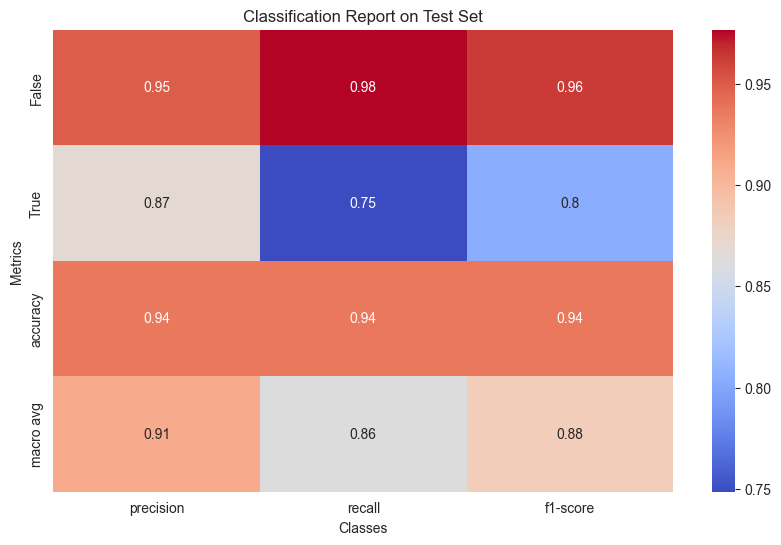

In [42]:
report = lr_test_cr
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Classification Report on Test Set')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

### Confusion Matrix

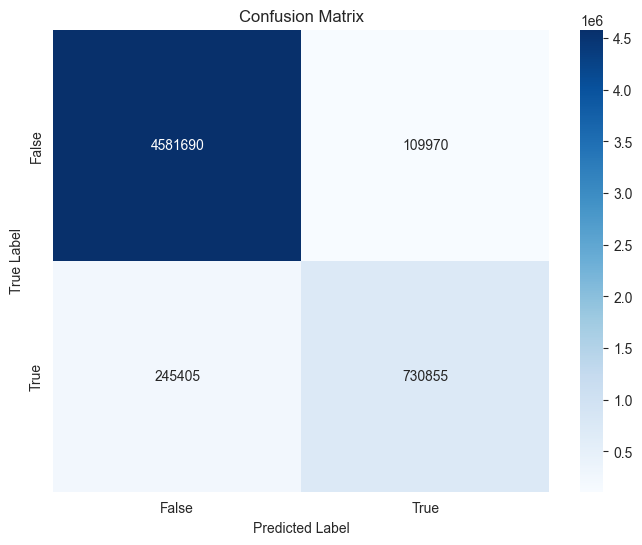

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(lr_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC Curve

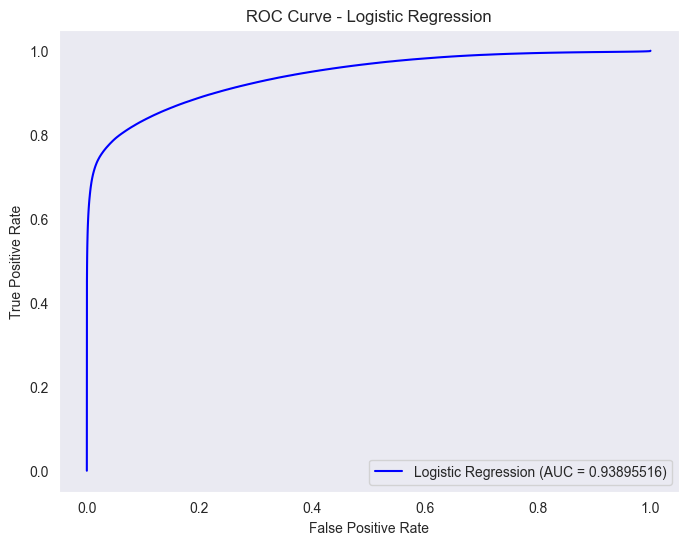

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.8f})', color='blue')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Precision-Recall Curve

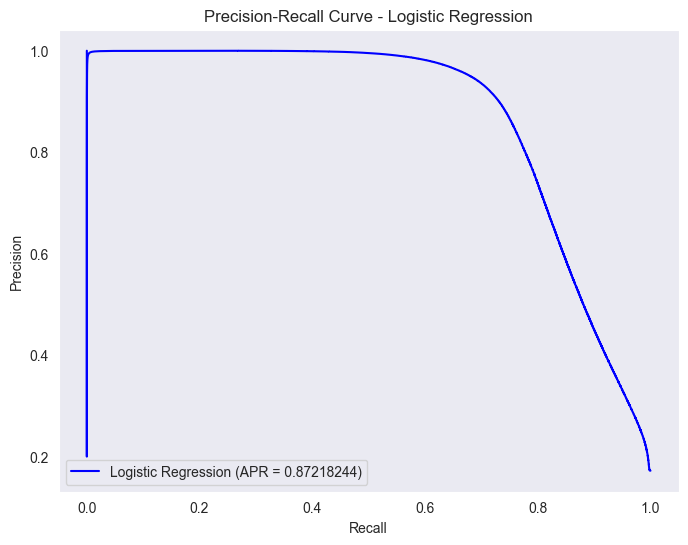

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (APR = {average_precision_lr:.8f})', color='blue')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# CatBoost

## Preliminaries

### Loading in The Dataset

In [49]:
df = pd.read_parquet('dataset/model_ready_data_airlines.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 23 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Dest               category
 3   CRSDepTime         int16   
 4   DepTime            int16   
 5   DepDel15           bool    
 6   ArrTime            int16   
 7   ArrDel15           bool    
 8   AirTime            int16   
 9   CRSElapsedTime     int16   
 10  ActualElapsedTime  int16   
 11  Distance           int16   
 12  Year               category
 13  Quarter            category
 14  Month              category
 15  DayofMonth         category
 16  DayOfWeek          category
 17  DepTimeBlk         category
 18  ArrTimeBlk         category
 19  TaxiOut            int16   
 20  TaxiIn             int16   
 21  CRSDepTimeMin      int16   
 22  DepTimeMin         int16   
dtypes: bool(2), category(10), int16(11)
memory usage: 973.0

## Data Preprocessing
The good thing about CatBoost is that, it doesn't require much data preprocessing. You can just pass in the categorical columns as an argument to CatBoostClassifier and it will automatically handle the rest.

### Training Test Split
Since, we have a lot of data (~28M rows), We will split Training and Testing into 80|20 and then split Training into 80|20 for validation.

In [ ]:
X = df.drop('DepDel15', axis=1)
y = df['DepDel15']

# We will stratify y to cater the imbalance
# Training/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training/Test split ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Training/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("Training/Validation split ", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Training/Test split  (22671676, 22) (22671676,) (5667920, 22) (5667920,)
Training/Validation split  (18137340, 22) (18137340,) (4534336, 22) (4534336,)


## Modeling

### Model Fitting

In [74]:
categorical_columns = df.select_dtypes('category').columns.tolist()

cb_model = CatBoostClassifier(
    task_type = 'GPU',
    iterations=100,
    depth=8,
    learning_rate=0.1,
    loss_function='CrossEntropy',
    cat_features=categorical_columns,
    verbose=40 # Print progress after every 40 iterations
)

# Train the model on the training data
cb_model.fit(X_train, y_train)

0:	learn: 0.5624100	total: 497ms	remaining: 49.2s
40:	learn: 0.1523049	total: 18.1s	remaining: 26.1s
80:	learn: 0.1123746	total: 34.8s	remaining: 8.17s
99:	learn: 0.0979360	total: 42.8s	remaining: 0us


### Model Prediction

In [75]:
# Make predictions on the validation set
cb_y_val_pred = cb_model.predict(X_val)

# Make predictions on the test set
cb_y_test_pred = cb_model.predict(X_test)

# Get probabilities for the positive class
cb_y_test_proba = cb_model.predict_proba(X_test)[:, 1]  

## Model Performance

### Score on Validation Set

In [76]:
cb_val_acc_score = accuracy_score(y_val, cb_y_val_pred)
cb_val_cr = classification_report(y_val, cb_y_val_pred)
cb_val_cm = confusion_matrix(y_val, cb_y_val_pred)

# Evaluate on validation data
print("Validation Accuracy:", accuracy_score(y_val, cb_y_val_pred))
print("Classification Report on Validation Set:\n", classification_report(y_val, cb_y_val_pred))
print("Confusion Matrix on Validation Set:\n", confusion_matrix(y_val, cb_y_val_pred))

Validation Accuracy: 0.9619344486160708
Classification Report on Validation Set:
               precision    recall  f1-score   support

       False       0.96      0.99      0.98   3753328
        True       0.96      0.81      0.88    781008

    accuracy                           0.96   4534336
   macro avg       0.96      0.90      0.93   4534336
weighted avg       0.96      0.96      0.96   4534336

Confusion Matrix on Validation Set:
 [[3729142   24186]
 [ 148416  632592]]


### Score on Test Set

In [77]:
cb_test_acc_score = accuracy_score(y_test, cb_y_test_pred)
cb_test_cr = classification_report(y_test, cb_y_test_pred, output_dict=True)
cb_test_cm = confusion_matrix(y_test, cb_y_test_pred)

# Evaluate on test data
print("Test Accuracy:", accuracy_score(y_test, cb_y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, cb_y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, cb_y_test_pred))

Test Accuracy: 0.9617542237716834
Classification Report on Test Set:
               precision    recall  f1-score   support

       False       0.96      0.99      0.98   4691660
        True       0.96      0.81      0.88    976260

    accuracy                           0.96   5667920
   macro avg       0.96      0.90      0.93   5667920
weighted avg       0.96      0.96      0.96   5667920

Confusion Matrix on Test Set:
 [[4661442   30218]
 [ 186556  789704]]


### ROC-AUC

In [84]:
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_y_test_proba)
roc_auc_cb = auc(fpr_cb, tpr_cb)

print("ROC-AUC: ", roc_auc_cb)

ROC-AUC:  0.9915977687851879


### Average Precision Score

In [85]:
precision_cb, recall_cb, _ = precision_recall_curve(y_test, cb_y_test_proba)
average_precision_cb = average_precision_score(y_test, cb_y_test_proba)

print("Area under Precision-Recall curve: ", average_precision_cb)

Area under Precision-Recall curve:  0.9699119390150541


## Visualization

### Feature Importance

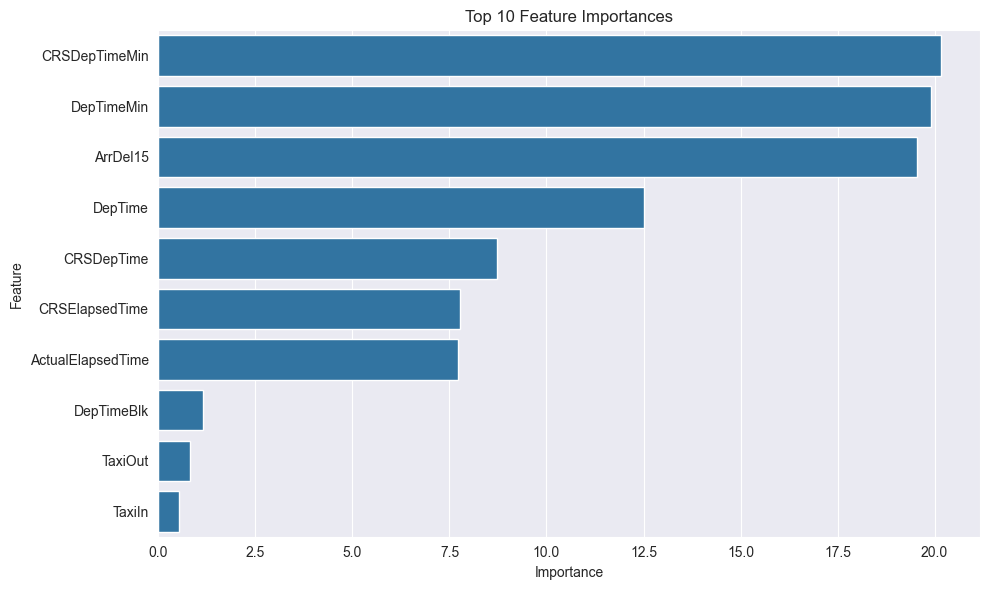

In [80]:
feature_importance = cb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

### Classification Report

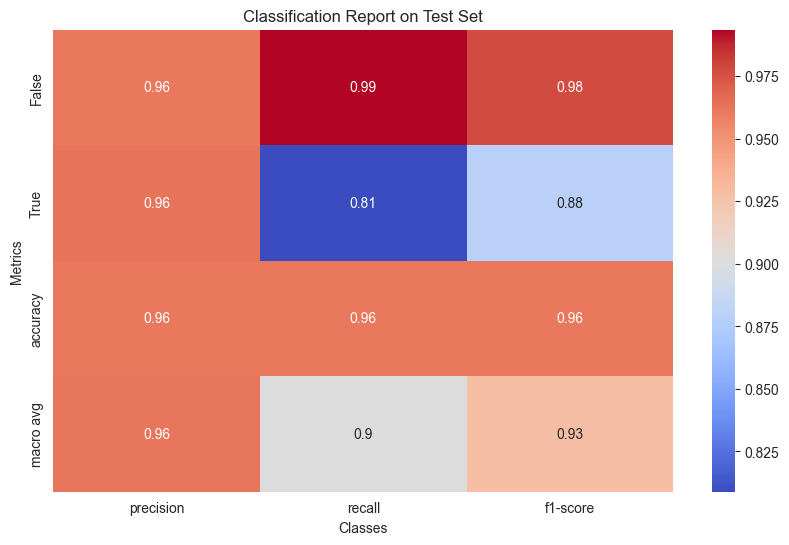

In [86]:
report = cb_test_cr
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Classification Report on Test Set')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

### Confusion Matrix

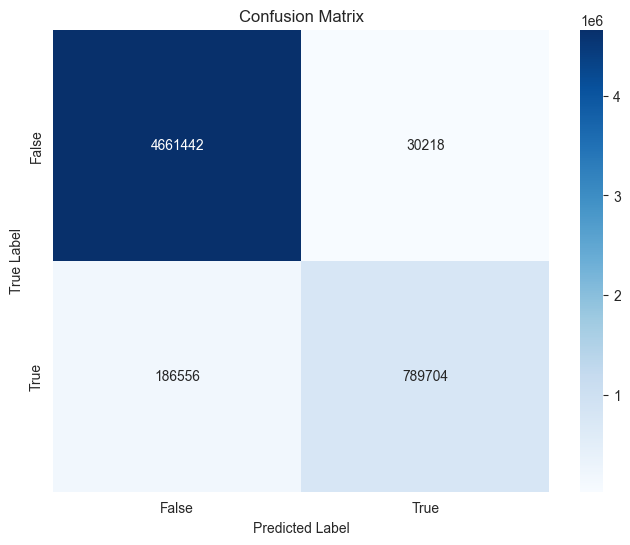

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(cb_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC Curve

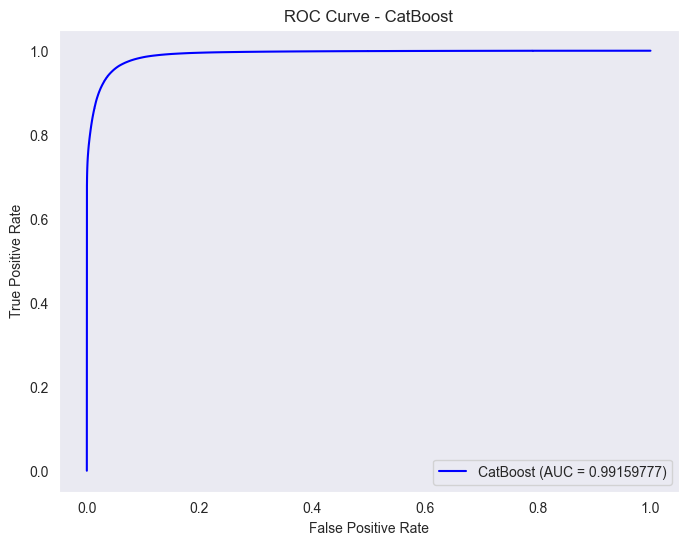

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {roc_auc_cb:.8f})', color='blue')
plt.title('ROC Curve - CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Precision-Recall Curve

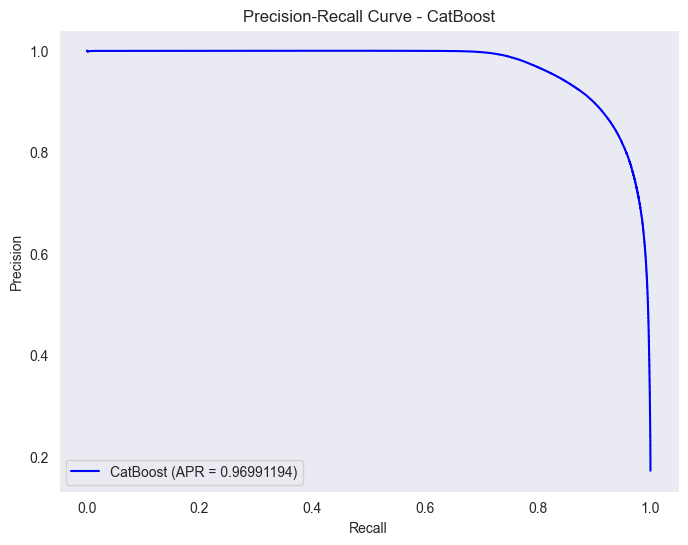

In [90]:
plt.figure(figsize=(8, 6))
plt.plot(recall_cb, precision_cb, label=f'CatBoost (APR = {average_precision_cb:.8f})', color='blue')
plt.title('Precision-Recall Curve - CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [6]:
# Create a stratified K-Folds cross-validator
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# # categorical_columns = df.drop('DepartureDiffCategory', axis=1).select_dtypes('category').columns.tolist()
# categorical_columns = df.select_dtypes('category').columns.tolist()
# # 
# cv_scores = []
# # 
# # # Iterate over each fold
# for train_index, val_index in kf.split(X, y):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
# 
#     model = CatBoostClassifier(task_type = 'GPU',
#                                iterations=110, 
#                                depth=12, 
#                                learning_rate=0.1, 
#                                loss_function='MultiClass',
#                                cat_features=categorical_columns,
#                                verbose=False)
#     model.fit(X_train, y_train)
# 
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     cv_scores.append(accuracy)
#     print(f"Validation Accuracy: {accuracy}")
# 
# print(cv_scores)


0:	learn: 0.6181397	total: 750ms	remaining: 1m 21s
1:	learn: 0.5565863	total: 1.29s	remaining: 1m 9s
2:	learn: 0.5053196	total: 1.81s	remaining: 1m 4s
3:	learn: 0.4623241	total: 2.46s	remaining: 1m 5s
4:	learn: 0.4253549	total: 3.03s	remaining: 1m 3s
5:	learn: 0.3938720	total: 3.61s	remaining: 1m 2s
6:	learn: 0.3667809	total: 4.23s	remaining: 1m 2s
7:	learn: 0.3432340	total: 4.83s	remaining: 1m 1s
8:	learn: 0.3228603	total: 5.43s	remaining: 1m
9:	learn: 0.3050839	total: 5.97s	remaining: 59.7s
10:	learn: 0.2891461	total: 6.48s	remaining: 58.3s
11:	learn: 0.2755141	total: 7s	remaining: 57.2s
12:	learn: 0.2629847	total: 7.52s	remaining: 56.1s
13:	learn: 0.2520053	total: 8.05s	remaining: 55.2s
14:	learn: 0.2426753	total: 8.68s	remaining: 54.9s
15:	learn: 0.2339918	total: 9.26s	remaining: 54.4s
16:	learn: 0.2267581	total: 9.88s	remaining: 54.1s
17:	learn: 0.2202525	total: 10.5s	remaining: 53.8s
18:	learn: 0.2138414	total: 11s	remaining: 52.7s
19:	learn: 0.2080932	total: 11.5s	remaining: 51.

# Support Vector Machine (Dropped)
We tried SVM and it takes forever to fit. Waited more than 4 hours but in vain. After searching on the internet, we found that SVM are computationally very costly and are not suitable for large datasets. It performs Logistic regression on the SVM’s scores, to get the probabilities, resulting in higher computation. Since our dataset is approxiamtely 28m rows long, SVM is not a suitable approach. SVM works well on data with small number of rows but many features.
Other models are providing promising results as well, so there is no need to implement this model.

## Preliminaries

### Loading in The Dataset

In [90]:
df = pd.read_parquet('dataset/model_ready_data_airlines.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 23 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Dest               category
 3   CRSDepTime         int16   
 4   DepTime            int16   
 5   DepDel15           bool    
 6   ArrTime            int16   
 7   ArrDel15           bool    
 8   AirTime            int16   
 9   CRSElapsedTime     int16   
 10  ActualElapsedTime  int16   
 11  Distance           int16   
 12  Year               category
 13  Quarter            category
 14  Month              category
 15  DayofMonth         category
 16  DayOfWeek          category
 17  DepTimeBlk         category
 18  ArrTimeBlk         category
 19  TaxiOut            int16   
 20  TaxiIn             int16   
 21  CRSDepTimeMin      int16   
 22  DepTimeMin         int16   
dtypes: bool(2), category(10), int16(11)
memory usage: 973.0

## Data Preprocessing

### Handling Categoricals
We will use **Frequency Encoding** which maps the values based on their occurences. Using something like label encoding won't be feasible for us as our categorical data is nominal.

In [91]:
categorical_columns = df.select_dtypes('category').columns.tolist()

for col in categorical_columns:
    df[col] = df[col].map(df[col].value_counts())

df.head()

,Airline,Origin,Dest,CRSDepTime,DepTime,DepDel15,ArrTime,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,CRSDepTimeMin,DepTimeMin
0,974640,3832,1347297,1202,1157,False,1256,False,38,62,59,145,5578617,7510343,2612385,935588,3938876,1762065,1731082,14,7,722,717
1,974640,3832,1347297,1202,1157,False,1258,False,36,62,61,145,5578617,7510343,2612385,936001,4004742,1762065,1731082,13,12,722,717
2,974640,3832,1347297,1202,1153,False,1302,False,40,62,69,145,5578617,7510343,2612385,919963,4196961,1762065,1731082,18,11,722,713
3,974640,3832,1347297,1202,1150,False,1253,False,35,62,63,145,5578617,7510343,2612385,926470,4228403,1762065,1731082,17,11,722,710
4,974640,3832,1347297,1400,1355,False,1459,False,36,60,64,145,5578617,7510343,2612385,932286,3618711,1731826,1662965,17,11,840,835


### Training Test Split
Since, we have a lot of data (~28M rows), We will split Training and Testing into 80|20 and then split Training into 80|20 for validation.

In [92]:
X = df.drop('DepDel15', axis=1)
y = df['DepDel15']

# We will stratify y to cater the imbalance
# Training/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training/Test split ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Training/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("Training/Validation split ", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Training/Test split  (22671676, 22) (22671676,) (5667920, 22) (5667920,)
Training/Validation split  (18137340, 22) (18137340,) (4534336, 22) (4534336,)


## Modeling

### Model Pipeline

In [12]:
svm_pipeline = Pipeline([
    # ('rus', RandomUnderSampler(random_state=42)),
    # ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True))
])

### Model Fitting

In [ ]:
svm_pipeline.fit(X_train, y_train)

### Model Prediction

In [ ]:
# Prediction on Validation Set
svm_y_val_pred = svm_pipeline.predict(X_val)

# Prediction on Test Set
svm_y_test_pred = svm_pipeline.predict(X_test)

## Model Performance

### Score on Validation Set

In [ ]:
svm_val_acc_score = accuracy_score(y_val, svm_y_val_pred)
svm_val_cr = classification_report(y_val, svm_y_val_pred)
svm_val_cm = confusion_matrix(y_val, svm_y_val_pred)

print("Validation Accuracy:", svm_val_acc_score)
print("Classification Report on Validation Set:\n", svm_val_cr)
print("Confusion Matrix on Validation Set:\n", svm_val_cm)

### Score on Test Set

In [ ]:
svm_test_acc_score = accuracy_score(y_test, svm_y_test_pred)
svm_test_cr = classification_report(y_test, svm_y_test_pred, output_dict=True)
svm_test_cm = confusion_matrix(y_test, svm_y_test_pred)

print("Test Accuracy:", accuracy_score(y_test, svm_y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, svm_y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, svm_y_test_pred))

## Visualization

### Classification Report

In [ ]:
report = svm_test_cr
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Classification Report on Test Set')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

### Confusion Matrix

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Random Forest

## Preliminaries

### Loading in The Dataset

In [2]:
df = pd.read_parquet('dataset/model_ready_data_airlines.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339596 entries, 0 to 28339595
Data columns (total 23 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Dest               category
 3   CRSDepTime         int16   
 4   DepTime            int16   
 5   DepDel15           bool    
 6   ArrTime            int16   
 7   ArrDel15           bool    
 8   AirTime            int16   
 9   CRSElapsedTime     int16   
 10  ActualElapsedTime  int16   
 11  Distance           int16   
 12  Year               category
 13  Quarter            category
 14  Month              category
 15  DayofMonth         category
 16  DayOfWeek          category
 17  DepTimeBlk         category
 18  ArrTimeBlk         category
 19  TaxiOut            int16   
 20  TaxiIn             int16   
 21  CRSDepTimeMin      int16   
 22  DepTimeMin         int16   
dtypes: bool(2), category(10), int16(11)
memory usage: 973.0

## Data Preprocessing

### Handling Categoricals
We will use **Frequency Encoding** which maps the values based on their occurences. Using something like label encoding won't be feasible for us as our categorical data is nominal.

In [3]:
categorical_columns = df.select_dtypes('category').columns.tolist()

for col in categorical_columns:
    df[col] = df[col].map(df[col].value_counts())

df.head()

,Airline,Origin,Dest,CRSDepTime,DepTime,DepDel15,ArrTime,ArrDel15,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DepTimeBlk,ArrTimeBlk,TaxiOut,TaxiIn,CRSDepTimeMin,DepTimeMin
0,974640,3832,1347297,1202,1157,False,1256,False,38,62,59,145,5578617,7510343,2612385,935588,3938876,1762065,1731082,14,7,722,717
1,974640,3832,1347297,1202,1157,False,1258,False,36,62,61,145,5578617,7510343,2612385,936001,4004742,1762065,1731082,13,12,722,717
2,974640,3832,1347297,1202,1153,False,1302,False,40,62,69,145,5578617,7510343,2612385,919963,4196961,1762065,1731082,18,11,722,713
3,974640,3832,1347297,1202,1150,False,1253,False,35,62,63,145,5578617,7510343,2612385,926470,4228403,1762065,1731082,17,11,722,710
4,974640,3832,1347297,1400,1355,False,1459,False,36,60,64,145,5578617,7510343,2612385,932286,3618711,1731826,1662965,17,11,840,835


### Training Test Split
Since, we have a lot of data (~28M rows), We will split Training and Testing into 80|20 and then split Training into 80|20 for validation.

In [4]:
X = df.drop('DepDel15', axis=1)
y = df['DepDel15']

# We will stratify y to cater the imbalance
# Training/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training/Test split ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Training/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("Training/Validation split ", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Training/Test split  (22671676, 22) (22671676,) (5667920, 22) (5667920,)
Training/Validation split  (18137340, 22) (18137340,) (4534336, 22) (4534336,)


## Modeling

### Model Fitting

In [5]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    random_state=42,
    class_weight='balanced', # Handle class imbalance
    verbose=1
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 48.3min


RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42, verbose=1)

### Model Prediction

In [7]:
# Make predictions on the validation set
rf_y_val_pred = rf_model.predict(X_val)

# Make predictions on the test set
rf_y_test_pred = rf_model.predict(X_test)

# Get probabilities for the positive class
rf_y_test_proba = rf_model.predict_proba(X_test)[:, 1]  

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min


## Model Performance

### Score on Validation Set

In [8]:
rf_val_acc_score = accuracy_score(y_val, rf_y_val_pred)
rf_val_cr = classification_report(y_val, rf_y_val_pred)
rf_val_cm = confusion_matrix(y_val, rf_y_val_pred)

print("Validation Accuracy:", rf_val_acc_score)
print("Classification Report on Validation Set:\n", rf_val_cr)
print("Confusion Matrix on Validation Set:\n", rf_val_cm)

Validation Accuracy: 0.9952751626699036
Classification Report on Validation Set:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00   3753328
        True       0.99      0.98      0.99    781008

    accuracy                           1.00   4534336
   macro avg       0.99      0.99      0.99   4534336
weighted avg       1.00      1.00      1.00   4534336

Confusion Matrix on Validation Set:
 [[3749111    4217]
 [  17207  763801]]


### Score on Test Set

In [9]:
rf_test_acc_score = accuracy_score(y_test, rf_y_test_pred)
rf_test_cr = classification_report(y_test, rf_y_test_pred, output_dict=True)
rf_test_cm = confusion_matrix(y_test, rf_y_test_pred)

print("Test Accuracy:", accuracy_score(y_test, rf_y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, rf_y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, rf_y_test_pred))

Test Accuracy: 0.9953040974466824
Classification Report on Test Set:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00   4691660
        True       0.99      0.98      0.99    976260

    accuracy                           1.00   5667920
   macro avg       1.00      0.99      0.99   5667920
weighted avg       1.00      1.00      1.00   5667920

Confusion Matrix on Test Set:
 [[4686558    5102]
 [  21514  954746]]


### ROC-AUC

In [10]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_test_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print("ROC-AUC: ", roc_auc_rf)

ROC-AUC:  0.999903375126671


### Average Precision Score

In [13]:
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_y_test_proba)
average_precision_rf = average_precision_score(y_test, rf_y_test_proba)

print("Area under Precision-Recall curve: ", average_precision_rf)

Area under Precision-Recall curve:  0.9994924411045601


## Visualization

### Feature Importance

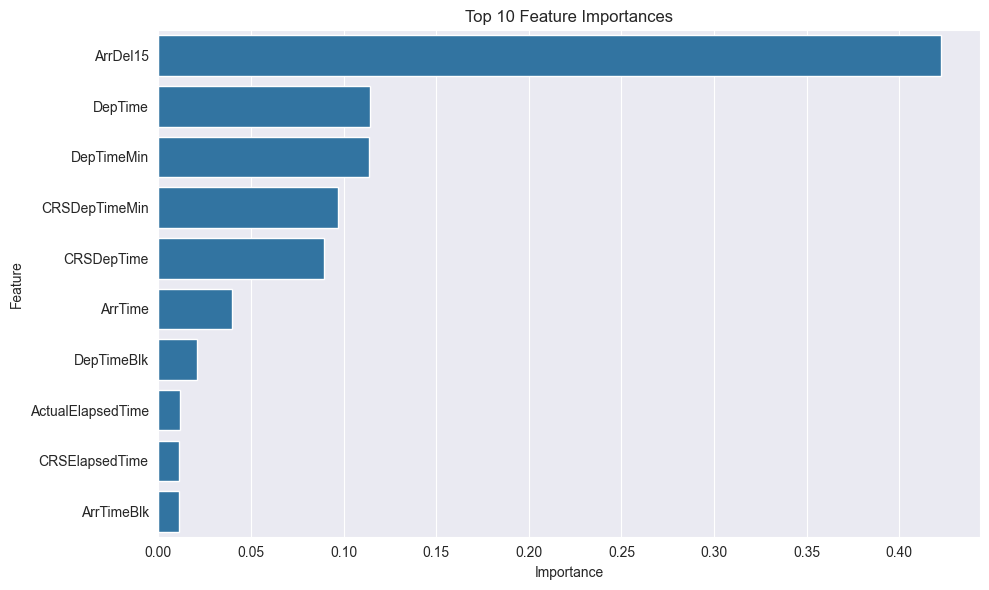

In [14]:
feature_importance = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

### Classification Report

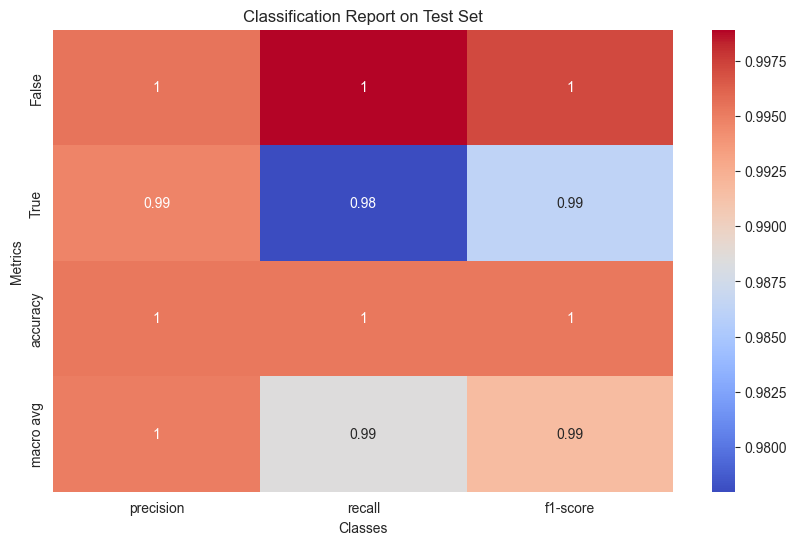

In [15]:
report = rf_test_cr
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Classification Report on Test Set')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

### Confusion Matrix

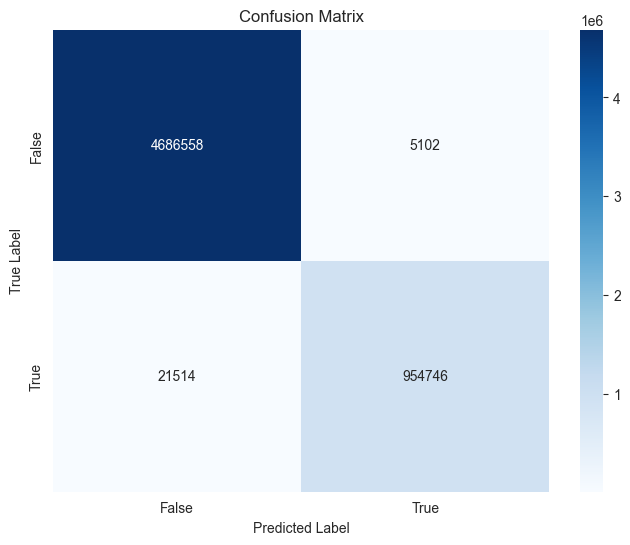

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(rf_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC Curve

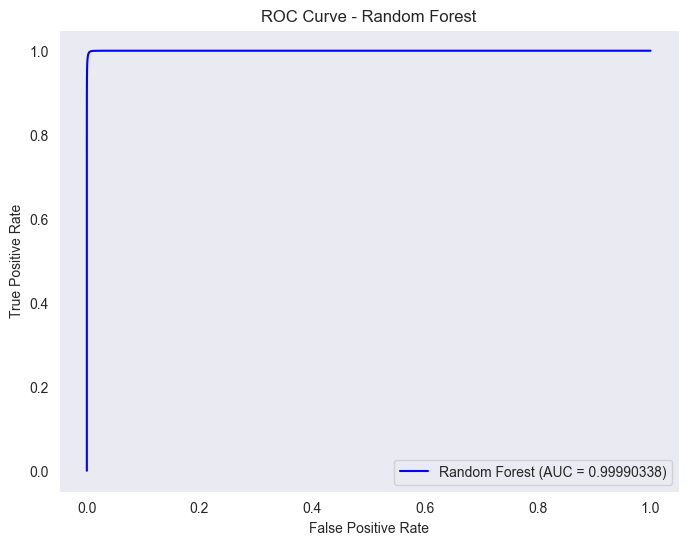

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', color='blue')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Precision-Recall Curve

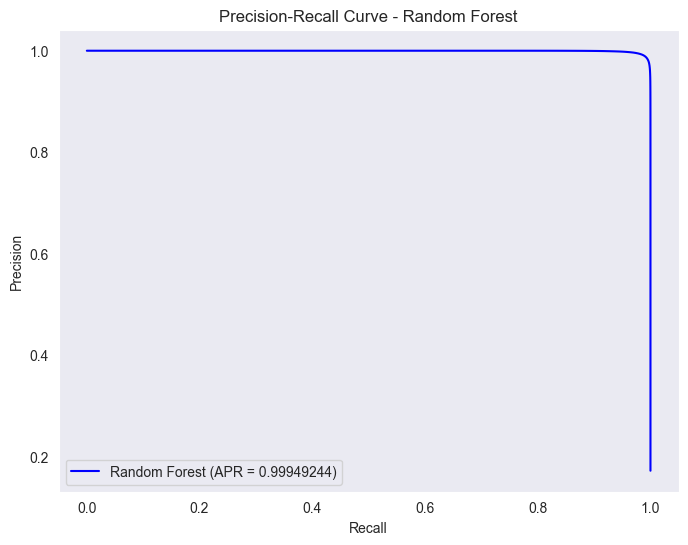

In [92]:
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (APR = {average_precision_rf:.8f})', color='blue')
plt.title('Precision-Recall Curve - Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Model Comparision

## Performance Comparision Table

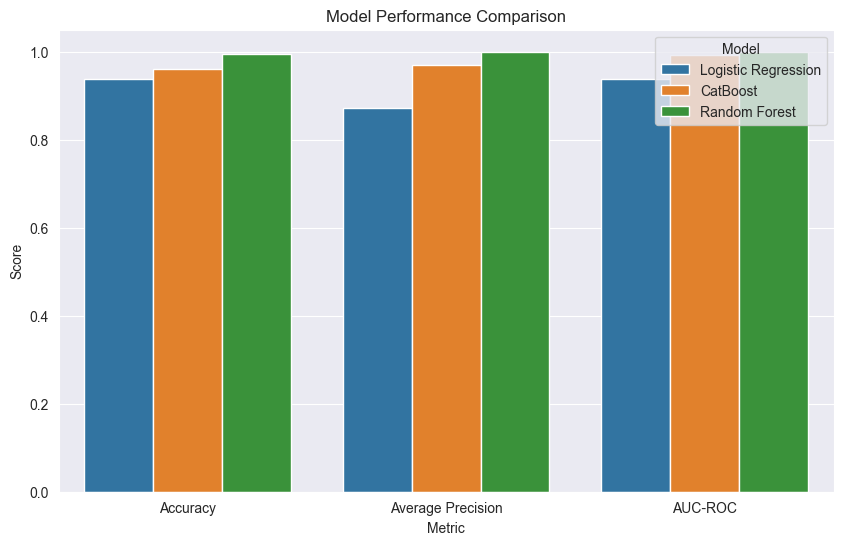

In [101]:
model_performance = {
    'Model': ['Logistic Regression', 'CatBoost', 'Random Forest'],
    'Accuracy': [lr_test_acc_score, cb_test_acc_score, rf_test_acc_score],
    'Average Precision': [average_precision_lr, average_precision_cb, average_precision_rf],
    'AUC-ROC': [roc_auc_lr, roc_auc_cb, roc_auc_rf],
}

df = pd.DataFrame(model_performance)
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()


## ROC Curve Comparision

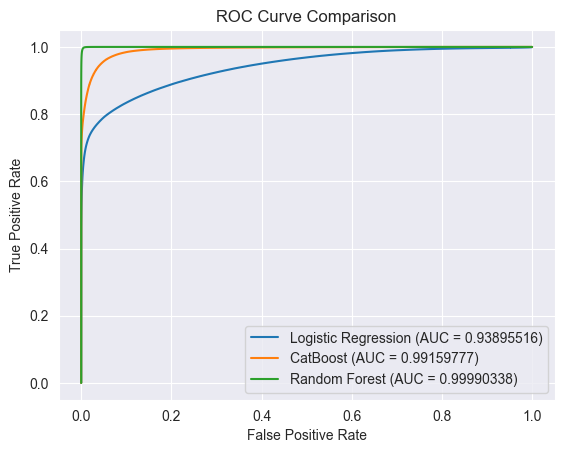

In [96]:
ROC_models = [[fpr_lr, tpr_lr, roc_auc_lr], [fpr_cb, tpr_cb, roc_auc_cb], [fpr_rf, tpr_rf, roc_auc_rf]]
model_names = ['Logistic Regression', 'CatBoost', 'Random Forest']

# ROC Curve Comparison
for roc, name in zip(ROC_models, model_names):
    plt.plot(roc[0], roc[1], label=f'{name} (AUC = {roc[2]:.8f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

## Precision-Recall Comparision

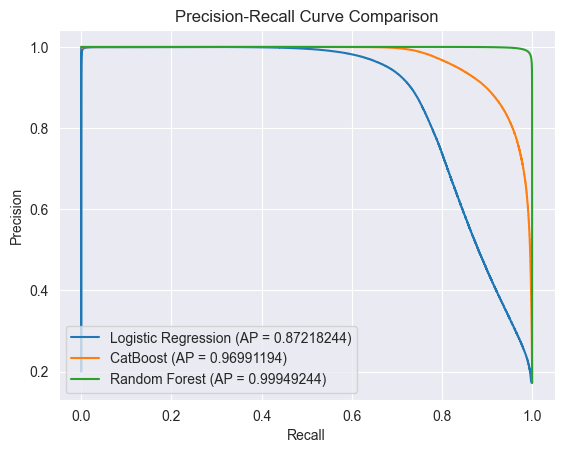

In [97]:
PRC_models = [[recall_lr, precision_lr, average_precision_lr], [recall_cb, precision_cb, average_precision_cb], [recall_rf, precision_rf, average_precision_rf]]
model_names = ['Logistic Regression', 'CatBoost', 'Random Forest']

# PR Curve Comparison
for prc, name in zip(PRC_models, model_names):
    plt.plot(prc[0], prc[1], label=f'{name} (AP = {prc[2]:.8f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.show()

# Final Remarks
From looking at the performances of all models together, we can clearly see that Random Forest Classifier has yielded the best results. Although, it is to be noted that Random Forest took the most time out of all to be trained (Approx. 1 hour). Since catboost leverages the power of the GPU, it completed complex computations in significantly less time (Approx. 1.5 min). Logistic Regression on the other hand, was the fastest to train (Approx. 1 min).

We had to drop SVM from our pool of models, since it took too long to train (Approx. 4 hours and still not finished). After researching, we found that SVM are computationally very costly and are not suitable for large datasets. It performs Logistic regression on the SVM’s scores, to get the probabilities, resulting in higher computation. Since our dataset is approximately 28m rows long, SVM is not a suitable approach. SVM works well on data with small number of rows but many features.


So the choice ultimately depends on the resources and desired accuracy.